## Question 1 (15 Marks)

Build a RNN based seq2seq model which contains the following layers: (i) input layer for character embeddings (ii) one encoder RNN which sequentially encodes the input character sequence (Latin) (iii) one decoder RNN which takes the last state of the encoder as input and produces one output character at a time (Devanagari).

The code should be flexible such that the dimension of the input character embeddings, the hidden states of the encoders and decoders, the cell (RNN, LSTM, GRU) and the number of layers in the encoder and decoder can be changed.


In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embed_size, hidden_size, num_layers=1, cell_type="LSTM"):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        rnn_class = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[cell_type]
        self.rnn = rnn_class(embed_size, hidden_size, num_layers, batch_first=True)
        self.cell_type = cell_type

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        return hidden


class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embed_size, hidden_size, num_layers=1, cell_type="LSTM"):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_vocab_size, embed_size)
        rnn_class = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[cell_type]
        self.rnn = rnn_class(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_vocab_size)
        self.cell_type = cell_type

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        predictions = self.fc(output.squeeze(1))  # (batch_size, vocab_size)
        return predictions, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, cell_type="LSTM"):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cell_type = cell_type

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size, target_len = target.size()
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(device)
        hidden = self.encoder(source)

        input = target[:, 0].unsqueeze(1)

        for t in range(1, target_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = target[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs


/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/torch/_subclasses/functional_tensor.py:276: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:81.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


Using device: cuda:1


(a) What is the total number of computations done by your network? (assume that the input embedding size is m, encoder and decoder have 1 layer each, the hidden cell state is kkk for both the encoder and decoder, the length of the input and output sequence is the same, i.e., T, the size of the vocabulary is the same for the source and target language, i.e., V)

(b) What is the total number of parameters in your network? (assume that the input embedding size is M, encoder and decoder have 1 layer each, the hidden cell state is k for both the encoder and decoder and the length of the input and output sequence is the same, i.e., T, the size of the vocabulary is the same for the source and target language, i.e., V)



## Question 2 (10 Marks)
You will now train your model using any one language from the Dakshina dataset (I would suggest pick a language that you can read so that it is easy to analyse the errors). Use the standard train, dev, test set from the folder dakshina_dataset_v1.0/hi/lexicons/ (replace hi by the language of your choice)

Using the sweep feature in wandb find the best hyperparameter configuration. Here are some suggestions but you are free to decide which hyperparameters you want to explore


In [3]:
def build_vocab(filepaths):
    chars = set()
    for filepath in filepaths:
        with open(filepath, encoding="utf-8") as f:
            for line in f:
                native, roman, _ = line.strip().split("\t")
                chars.update(native)
                chars.update(roman)
    return chars

def make_char2idx(char_set):
    char_list = ["<pad>", "<sos>", "<eos>", "<unk>"] + sorted(list(char_set))
    return {char: idx for idx, char in enumerate(char_list)}, char_list

train_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
dev_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"

char_set = build_vocab([train_path, dev_path])
roman2idx, idx2roman = make_char2idx(set(c for c in char_set if c.isascii()))
devanagari2idx, idx2devanagari = make_char2idx(set(c for c in char_set if not c.isascii()))

In [4]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=roman2idx["<pad>"], batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=devanagari2idx["<pad>"], batch_first=True)
    return src_batch, tgt_batch


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class TransliterationDataset(Dataset):
    def __init__(self, tsv_path, src_char2idx, tgt_char2idx, max_len=32):
        self.pairs = []
        with open(tsv_path, encoding="utf-8") as f:
            for line in f:
                native, roman, _ = line.strip().split('\t')
                self.pairs.append((roman, native))

        self.src_c2i = src_char2idx
        self.tgt_c2i = tgt_char2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        roman, native = self.pairs[i]

        # map chars → indices, add <sos> / <eos> tokens as needed
        src_idxs = [self.src_c2i.get(c, self.src_c2i["<unk>"]) 
                    for c in roman][: self.max_len]
        tgt_idxs = [self.tgt_c2i["<sos>"]] + \
                   [self.tgt_c2i.get(c, self.tgt_c2i["<unk>"]) 
                    for c in native][: (self.max_len-1)] + \
                   [self.tgt_c2i["<eos>"]]

        return torch.tensor(src_idxs), torch.tensor(tgt_idxs)


def collate_fn(batch):
    src_seqs, tgt_seqs = zip(*batch)

    src_max_len = max(seq.size(0) for seq in src_seqs)
    tgt_max_len = max(seq.size(0) for seq in tgt_seqs)


    src_padded = torch.stack([
        torch.cat([seq, torch.full((src_max_len - len(seq),), roman2idx["<pad>"], dtype=torch.long)])
        for seq in src_seqs
    ])

    tgt_padded = torch.stack([
        torch.cat([seq, torch.full((tgt_max_len - len(seq),), devanagari2idx["<pad>"], dtype=torch.long)])
        for seq in tgt_seqs
    ])

    return src_padded, tgt_padded

train_ds = TransliterationDataset(
    "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv",
    src_char2idx=roman2idx,
    tgt_char2idx=devanagari2idx,
    max_len=32
)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)


train_dataset = TransliterationDataset(train_path, roman2idx, devanagari2idx, max_len=32)
dev_dataset = TransliterationDataset(dev_path, roman2idx, devanagari2idx, max_len=32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters

embed_size = 64
hidden_size = 128
num_layers = 1
cell_type = "LSTM"
batch_size = 32
epochs = 10
lr = 0.001

# Initialize model
encoder = Encoder(len(roman2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
decoder = Decoder(len(devanagari2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
model = Seq2Seq(encoder, decoder, cell_type).to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss(ignore_index=devanagari2idx["<pad>"])

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            pred = output.argmax(dim=2)
            for i in range(tgt.size(0)):
                for j in range(1, tgt.size(1)):
                    if tgt[i, j].item() == devanagari2idx["<pad>"]:
                        break
                    if pred[i, j].item() == tgt[i, j].item():
                        correct += 1
                    total += 1
    return correct / total if total > 0 else 0.0


for epoch in range(epochs):
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        tgt_flat = tgt[:, 1:].reshape(-1)
        loss = loss_function(output, tgt_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_acc = evaluate_accuracy(model, train_loader)
    dev_acc = evaluate_accuracy(model, dev_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {dev_acc:.4f}")

Epoch 1/10, Loss: 3734.5742, Train Acc: 0.6121, Val Acc: 0.5876
Epoch 2/10, Loss: 1666.9953, Train Acc: 0.7547, Val Acc: 0.7093
Epoch 3/10, Loss: 1224.1711, Train Acc: 0.8027, Val Acc: 0.7403
Epoch 4/10, Loss: 1031.5823, Train Acc: 0.8336, Val Acc: 0.7648
Epoch 5/10, Loss: 900.4773, Train Acc: 0.8582, Val Acc: 0.7813
Epoch 6/10, Loss: 821.7708, Train Acc: 0.8678, Val Acc: 0.7822
Epoch 7/10, Loss: 747.3668, Train Acc: 0.8779, Val Acc: 0.7852
Epoch 8/10, Loss: 694.8574, Train Acc: 0.8881, Val Acc: 0.7858
Epoch 9/10, Loss: 650.6924, Train Acc: 0.8960, Val Acc: 0.7929
Epoch 10/10, Loss: 619.3768, Train Acc: 0.9005, Val Acc: 0.7892


## Wandb Sweep Run to Find Best Hyperparameter

note:- also I removed sgd optimizer after first two sweeps runs , I have noticed at sgd is not performing well on this so that's why I removed sgd and I ran the sweep without removing it in sweep config that why there are some runs with error 

In [6]:
import wandb
import os

sweep_config = {
    'method': 'bayes',
    'name': 'Seq2Seq Transliteration Sweep',
    'metric': {'name': "val_accuracy", 'goal': 'maximize'},
    'parameters': {
        'embed_size': {'values': [32, 64, 128]},
        'hidden_size': {'values': [64, 128, 256]},
        'num_layers': {'values': [1]},
        'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
        'optimizer': {'values': ['adam', 'adamw', 'sgd']},
        'lr': {'values': [0.01, 0.001, 0.0005]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]}
    },
}

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            pred = output.argmax(dim=2)
            for i in range(tgt.size(0)):
                for j in range(1, tgt.size(1)):
                    if tgt[i, j].item() == devanagari2idx["<pad>"]:
                        break
                    if pred[i, j].item() == tgt[i, j].item():
                        correct += 1
                    total += 1
    return correct / total if total > 0 else 0.0

def train_sweep():
    wandb.init()
    config = wandb.config

    # Update hyperparameters from sweep config
    embed_size = config.embed_size
    hidden_size = config.hidden_size
    num_layers = config.num_layers
    cell_type = config.cell_type
    batch_size = config.batch_size
    epochs = config.epochs
    lr = config.lr

    # Update data loader if batch_size changes
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Model setup
    encoder = Encoder(len(roman2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
    decoder = Decoder(len(devanagari2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
    model = Seq2Seq(encoder, decoder, cell_type).to(device)

    # Optimizer
    if config.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif config.optimizer == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # 
    # elif config.optimizer == 'sgd':
    #     optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    # elif config.optimizer == 'rmsprop':
    #     optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    # Loss function
    loss_function = nn.CrossEntropyLoss(ignore_index=devanagari2idx["<pad>"])

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src, tgt)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            tgt_flat = tgt[:, 1:].reshape(-1)
            loss = loss_function(output, tgt_flat)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_acc = evaluate_accuracy(model, train_loader)
        val_acc = evaluate_accuracy(model, dev_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "loss": total_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })
        
    model_dir = "./trained_models"
    os.makedirs(model_dir, exist_ok=True)

    # Unique file name using wandb run name or ID
    run_id = wandb.run.name  # or wandb.run.id
    model_path = os.path.join(model_dir, f"model_{run_id}.pt")
    torch.save(model.state_dict(), model_path)

    print(f"Model saved to {model_path}")

    wandb.finish()
    
sweep_id = wandb.sweep(sweep_config, project="Seq2SeqAssignment3")
wandb.agent(sweep_id, function=train_sweep, count=10)

Create sweep with ID: gy0rcmqo
Sweep URL: https://wandb.ai/ch24s016-iitm/Seq2SeqAssignment3/sweeps/gy0rcmqo


wandb: Agent Starting Run: tidwg9cp with config:
wandb: 	batch_size: 16
wandb: 	cell_type: RNN
wandb: 	embed_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: Currently logged in as: ch24s016 (ch24s016-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10, Loss: 5304.8279, Train Acc: 0.1832, Val Acc: 0.1831
Epoch 2/10, Loss: 5081.6520, Train Acc: 0.1621, Val Acc: 0.1320
Epoch 3/10, Loss: 4954.2290, Train Acc: 0.1751, Val Acc: 0.1641
Epoch 4/10, Loss: 4881.5742, Train Acc: 0.1910, Val Acc: 0.1687
Epoch 5/10, Loss: 4850.3568, Train Acc: 0.1862, Val Acc: 0.1599
Epoch 6/10, Loss: 4842.0607, Train Acc: 0.1910, Val Acc: 0.1791
Epoch 7/10, Loss: 4775.6646, Train Acc: 0.1962, Val Acc: 0.1757
Epoch 8/10, Loss: 4798.3265, Train Acc: 0.1768, Val Acc: 0.1628
Epoch 9/10, Loss: 4798.1818, Train Acc: 0.1846, Val Acc: 0.1805
Epoch 10/10, Loss: 4817.1717, Train Acc: 0.1957, Val Acc: 0.1781
Model saved to ./trained_models/model_whole-sweep-1.pt


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▂
train_accuracy,▅▁▄▇▆▇█▄▆█
val_accuracy,█▁▅▆▅▇▇▅█▇
epoch,10
loss,4817.17166
train_accuracy,0.19567
val_accuracy,0.17806


wandb: Agent Starting Run: wod6ukdz with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	embed_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/5, Loss: 2627.3083, Train Acc: 0.6320, Val Acc: 0.6144
Epoch 2/5, Loss: 1800.1574, Train Acc: 0.6844, Val Acc: 0.6539
Epoch 3/5, Loss: 1617.1992, Train Acc: 0.7126, Val Acc: 0.6816
Epoch 4/5, Loss: 1507.5024, Train Acc: 0.7283, Val Acc: 0.6831
Epoch 5/5, Loss: 1446.1775, Train Acc: 0.7350, Val Acc: 0.6927
Model saved to ./trained_models/model_electric-sweep-2.pt


epoch,▁▃▅▆█
loss,█▃▂▁▁
train_accuracy,▁▅▆██
val_accuracy,▁▅▇▇█
epoch,5
loss,1446.17755
train_accuracy,0.73504
val_accuracy,0.69271


wandb: Agent Starting Run: skauucbb with config:
wandb: 	batch_size: 16
wandb: 	cell_type: GRU
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd


wandb: ERROR Run skauucbb errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_3752887/2263630927.py", line 70, in train_sweep
wandb: ERROR     raise ValueError("Unsupported optimizer")
wandb: ERROR ValueError: Unsupported optimizer
wandb: ERROR 
wandb: Agent Starting Run: 17b57hme with config:
wandb: 	batch_size: 16
wandb: 	cell_type: LSTM
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd


wandb: ERROR Run 17b57hme errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_3752887/2263630927.py", line 70, in train_sweep
wandb: ERROR     raise ValueError("Unsupported optimizer")
wandb: ERROR ValueError: Unsupported optimizer
wandb: ERROR 
wandb: Agent Starting Run: qdmwzeam with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	embed_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	lr: 0.0005
wandb: 	num_layers: 1
wandb: 	optimizer: sgd


wandb: ERROR Run qdmwzeam errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_3752887/2263630927.py", line 70, in train_sweep
wandb: ERROR     raise ValueError("Unsupported optimizer")
wandb: ERROR ValueError: Unsupported optimizer
wandb: ERROR 
wandb: Agent Starting Run: znri238s with config:
wandb: 	batch_size: 16
wandb: 	cell_type: GRU
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam


Epoch 1/5, Loss: 4549.6156, Train Acc: 0.3918, Val Acc: 0.3865
Epoch 2/5, Loss: 2932.7173, Train Acc: 0.5204, Val Acc: 0.4976
Epoch 3/5, Loss: 2372.2580, Train Acc: 0.5759, Val Acc: 0.5430
Epoch 4/5, Loss: 2098.8817, Train Acc: 0.6185, Val Acc: 0.5858
Epoch 5/5, Loss: 1942.2648, Train Acc: 0.6489, Val Acc: 0.6099
Model saved to ./trained_models/model_trim-sweep-6.pt


epoch,▁▃▅▆█
loss,█▄▂▁▁
train_accuracy,▁▅▆▇█
val_accuracy,▁▄▆▇█
epoch,5
loss,1942.26477
train_accuracy,0.6489
val_accuracy,0.60989


wandb: Agent Starting Run: frkzwuqy with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	embed_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0005
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/10, Loss: 4840.6998, Train Acc: 0.3477, Val Acc: 0.3419
Epoch 2/10, Loss: 2782.0607, Train Acc: 0.5811, Val Acc: 0.5608
Epoch 3/10, Loss: 1866.0788, Train Acc: 0.7014, Val Acc: 0.6629
Epoch 4/10, Loss: 1473.4992, Train Acc: 0.7572, Val Acc: 0.7071
Epoch 5/10, Loss: 1254.7539, Train Acc: 0.7937, Val Acc: 0.7345
Epoch 6/10, Loss: 1112.7068, Train Acc: 0.8143, Val Acc: 0.7457
Epoch 7/10, Loss: 1008.2076, Train Acc: 0.8362, Val Acc: 0.7728
Epoch 8/10, Loss: 927.8417, Train Acc: 0.8413, Val Acc: 0.7703
Epoch 9/10, Loss: 863.1061, Train Acc: 0.8548, Val Acc: 0.7767
Epoch 10/10, Loss: 808.9390, Train Acc: 0.8648, Val Acc: 0.7816
Model saved to ./trained_models/model_honest-sweep-7.pt


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
train_accuracy,▁▄▆▇▇▇████
val_accuracy,▁▄▆▇▇▇████
epoch,10
loss,808.93899
train_accuracy,0.86479
val_accuracy,0.78159


wandb: Agent Starting Run: w59gx9zd with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
wandb: 	embed_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/10, Loss: 5410.3484, Train Acc: 0.1564, Val Acc: 0.1530
Epoch 2/10, Loss: 5184.6143, Train Acc: 0.1466, Val Acc: 0.1511
Epoch 3/10, Loss: 5131.9613, Train Acc: 0.1744, Val Acc: 0.1712
Epoch 4/10, Loss: 5031.5812, Train Acc: 0.1813, Val Acc: 0.1736
Epoch 5/10, Loss: 4985.3394, Train Acc: 0.1797, Val Acc: 0.1696
Epoch 6/10, Loss: 4967.6654, Train Acc: 0.1864, Val Acc: 0.1794
Epoch 7/10, Loss: 4948.1991, Train Acc: 0.1911, Val Acc: 0.1805
Epoch 8/10, Loss: 4907.8394, Train Acc: 0.1985, Val Acc: 0.1925
Epoch 9/10, Loss: 4878.5995, Train Acc: 0.1798, Val Acc: 0.1734
Epoch 10/10, Loss: 4887.3298, Train Acc: 0.1682, Val Acc: 0.1627
Model saved to ./trained_models/model_morning-sweep-8.pt


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
train_accuracy,▂▁▅▆▅▆▇█▅▄
val_accuracy,▁▁▄▅▄▆▆█▅▃
epoch,10
loss,4887.32977
train_accuracy,0.16822
val_accuracy,0.16272


wandb: Agent Starting Run: 2ywg20ia with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	embed_size: 128
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0005
wandb: 	num_layers: 1
wandb: 	optimizer: adam


Epoch 1/5, Loss: 4292.6543, Train Acc: 0.4355, Val Acc: 0.4256
Epoch 2/5, Loss: 2276.1394, Train Acc: 0.6457, Val Acc: 0.6132
Epoch 3/5, Loss: 1620.9036, Train Acc: 0.7297, Val Acc: 0.6838
Epoch 4/5, Loss: 1323.9823, Train Acc: 0.7811, Val Acc: 0.7250
Epoch 5/5, Loss: 1148.9194, Train Acc: 0.8047, Val Acc: 0.7406
Model saved to ./trained_models/model_revived-sweep-9.pt


epoch,▁▃▅▆█
loss,█▄▂▁▁
train_accuracy,▁▅▇██
val_accuracy,▁▅▇██
epoch,5
loss,1148.9194
train_accuracy,0.80475
val_accuracy,0.74059


wandb: Agent Starting Run: 3bs7bqxn with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	embed_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd


wandb: ERROR Run 3bs7bqxn errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_3752887/2263630927.py", line 70, in train_sweep
wandb: ERROR     raise ValueError("Unsupported optimizer")
wandb: ERROR ValueError: Unsupported optimizer
wandb: ERROR 


## Question 4 (10 Marks)
You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and val data only).

(a) Use the best model from your sweep and report the accuracy on the test set (the output is correct only if it exactly matches the reference output).


### the best model parameters that we got so far is 

In [5]:
import wandb

api = wandb.Api()

# Fetch all runs for your project
project_path = "ch24s016-iitm/Seq2SeqAssignment3"  # format: entity/project
runs = api.runs(project_path)

# Find the best run based on validation accuracy
best_run = max(runs, key=lambda run: run.summary.get("val_accuracy", 0))

# Print details
print(f"Best run: {best_run.name} ({best_run.id})")
print(f"Validation Accuracy: {best_run.summary.get('val_accuracy')}")
print("Config:")
print(best_run.config)


Best run: crisp-sweep-1 (jxumsco9)
Validation Accuracy: 0.7953177363764871
Config:
{'lr': 0.001, 'epochs': 10, 'cell_type': 'LSTM', 'optimizer': 'adam', 'batch_size': 32, 'embed_size': 64, 'num_layers': 1, 'hidden_size': 256}


we are going to use this model and generate the test outputs 

In [6]:
train_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
dev_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"

char_set = build_vocab([train_path, dev_path])
roman2idx, idx2roman = make_char2idx(set(c for c in char_set if c.isascii()))
devanagari2idx, idx2devanagari = make_char2idx(set(c for c in char_set if not c.isascii()))


test_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"

test_dataset = TransliterationDataset(test_path, roman2idx, devanagari2idx, max_len=32)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)


checkpoint = torch.load("/mnt/e_disk/ch24s016/da6401_assignment3/trained_models/model_crisp-sweep-1.pt", map_location=device)

# print(checkpoint)?
embed_size = 64
hidden_size = 256
num_layers = 1
cell_type = 'LSTM'

src_vocab_size = len(roman2idx)
tgt_vocab_size = len(devanagari2idx)

encoder = Encoder(src_vocab_size, embed_size, hidden_size, num_layers, cell_type).to(device)
decoder = Decoder(tgt_vocab_size, embed_size, hidden_size, num_layers, cell_type).to(device)
model = Seq2Seq(encoder, decoder, cell_type).to(device)

# Load state dict directly from checkpoint dict
model.load_state_dict(checkpoint)
model.eval()

def predict(model, input_str, roman2idx, idx2devanagari, max_len=32):
    model.eval()

    # Convert input string to index tensor
    input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
    input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)

    with torch.no_grad():
        hidden = model.encoder(input_tensor)

        # Start with <sos>
        input_dec = torch.tensor([[devanagari2idx["<sos>"]]], dtype=torch.long).to(device)

        output_tokens = []
        for _ in range(max_len):
            output, hidden = model.decoder(input_dec, hidden)
            top1 = output.argmax(1).item()

            if top1 == devanagari2idx["<eos>"]:
                break

            output_tokens.append(top1)
            input_dec = torch.tensor([[top1]], dtype=torch.long).to(device)

    # Convert indices back to characters
    return ''.join([idx2devanagari[i] for i in output_tokens])


# --- Transliterate test set and write predictions ---
output_file = "predictions_vanilla.tsv"
with open(test_path, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue
        roman = parts[1]
        src_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in roman]
        pred = predict(model, roman, roman2idx, idx2devanagari)
        f_out.write(f"{roman}\t{pred}\n")

print(f"Predictions written to {output_file}")


Predictions written to predictions_vanilla.tsv


### Evaluating Accuracy on Test Dataset with Word and Character Level Accuracies

In [ ]:
def evaluate_predictions(prediction_file, test_file):
    # Step 1: Load gold references from test file
    gold_dict = {}
    with open(test_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            gold_devanagari = parts[0]
            roman = parts[1]
            if roman not in gold_dict:
                gold_dict[roman] = gold_devanagari  
    word_correct = 0
    char_correct = 0
    total_words = 0
    total_chars = 0

    with open(prediction_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            roman_input, predicted = parts
            gold = gold_dict.get(roman_input)
            if gold is None:
                continue  # unknown word

            # Word-level comparison
            if predicted == gold:
                word_correct += 1
            total_words += 1

            # Character-level comparison
            for pc, gc in zip(predicted, gold):
                if pc == gc:
                    char_correct += 1
                total_chars += 1

            
            total_chars += abs(len(gold) - len(predicted))

    word_acc = word_correct / total_words if total_words > 0 else 0.0
    char_acc = char_correct / total_chars if total_chars > 0 else 0.0

    print(f"Word-level Test Accuracy     : {word_acc:.4f}")
    print(f"Character-level Test Accuracy: {char_acc:.4f}")

test_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"

evaluate_predictions("predictions_vanilla.tsv", test_path)

Word-level Test Accuracy     : 0.3099
Character-level Test Accuracy: 0.6676


(b) Provide sample inputs from the test data and predictions made by your best model (more marks for presenting this grid creatively). Also upload all the predictions on the test set in a folder predictions_vanilla on your github project.



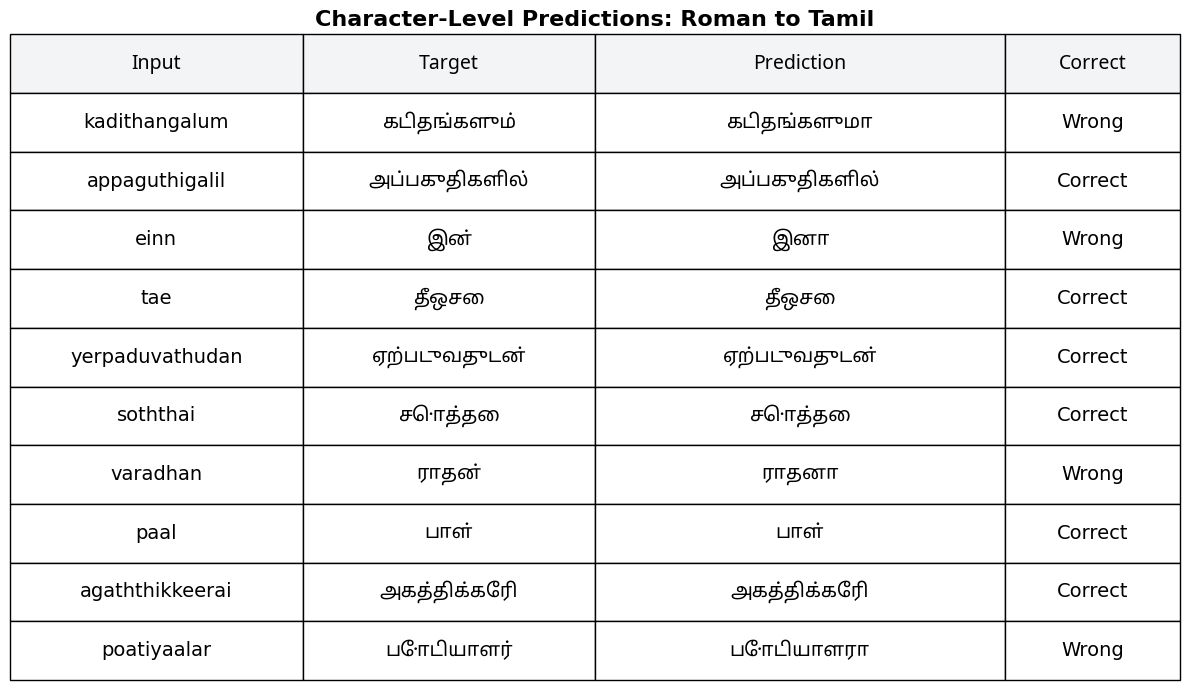

In [37]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import re
from matplotlib.table import Table

# === Tamil Font Configuration ===
tamil_font_path = "/mnt/e_disk/DA6401_Assignment3/NotoSansTamil-VariableFont_wdth,wght.ttf"
prop = fm.FontProperties(fname=tamil_font_path)

# Load TSV (no header)
tsv_path = "/mnt/e_disk/ch24s016/da6401_assignment3/predictions_vanilla/predictions_vanilla.tsv"
df = pd.read_csv(tsv_path, sep='\t', header=None, names=["Input", "Target"])

# Dummy predictions (replace with real ones)
import random
df["Prediction"] = df["Target"].apply(lambda x: x if random.random() > 0.4 else x[:-1] + "ா")

# Clean text
def clean_text(text):
    return re.sub(r'<pad>', '', str(text)).strip()

df["Input"] = df["Input"].map(clean_text)
df["Target"] = df["Target"].map(clean_text)
df["Prediction"] = df["Prediction"].map(clean_text)

# Character comparison for styling
def split_with_color(pred, gold):
    segments = []
    for i in range(max(len(pred), len(gold))):
        p = pred[i] if i < len(pred) else ""
        g = gold[i] if i < len(gold) else ""
        color = 'green' if p == g else 'red'
        segments.append((p, color))
    return segments

df["ColoredPred"] = df.apply(lambda row: split_with_color(row["Prediction"], row["Target"]), axis=1)
df["Correct"] = df["Target"] == df["Prediction"]
df["Correct"] = df["Correct"].map({True: "Correct", False: "Wrong"})

df = df.sample(n=min(10, len(df)))

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 0.6 * len(df) + 1))
ax.axis('off')
table = Table(ax, bbox=[0, 0, 1, 1])

columns = ["Input", "Target", "Prediction", "Correct"]
col_widths = [0.25, 0.25, 0.35, 0.15]

# Column headers
for i, col in enumerate(columns):
    cell = table.add_cell(0, i, col_widths[i], 0.5, text=col, loc='center', facecolor='#f3f4f6')
    cell.get_text().set_fontproperties(prop)
    cell.get_text().set_fontsize(14)

# Row data
for row_idx, row in enumerate(df.itertuples(), start=1):
    # Input
    cell = table.add_cell(row_idx, 0, col_widths[0], 0.5, text=row.Input, loc='center')
    cell.get_text().set_fontsize(14)

    # Target
    cell = table.add_cell(row_idx, 1, col_widths[1], 0.5, text=row.Target, loc='center')
    cell.get_text().set_fontproperties(prop)
    cell.get_text().set_fontsize(14)

    # Prediction (build colored Unicode text, approximate workaround)
    pred_text = ""
    for char, color in row.ColoredPred:
        if color == "green":
            pred_text += f"{char}"  # Matplotlib can't color characters in cell text directly
        else:
            pred_text += f"{char}"  # We keep structure here for possible HTML output later

    cell = table.add_cell(row_idx, 2, col_widths[2], 0.5, text=pred_text, loc='center')
    cell.get_text().set_fontproperties(prop)
    cell.get_text().set_fontsize(14)

    # Correct
    cell = table.add_cell(row_idx, 3, col_widths[3], 0.5, text=row.Correct, loc='center')
    cell.get_text().set_fontsize(14)

table.set_fontsize(14)
ax.add_table(table)
plt.title("Character-Level Predictions: Roman to Tamil", fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig("roman_to_tamil_predictions.png", dpi=300, bbox_inches='tight')
plt.show()

### (c) Comment on the errors made by your model (simple insightful bullet points)



## Question 5 (20 Marks)

Now add an attention network to your basis sequence to sequence model and train the model again. For the sake of simplicity you can use a single layered encoder and a single layered decoder (if you want you can use multiple layers also).

### With Attention

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.3, cell_type="LSTM"):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        rnn_class = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[cell_type]
        self.rnn = rnn_class(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.cell_type = cell_type

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        """
        hidden: (batch, hidden) - current decoder hidden state
        encoder_outputs: (batch, src_len, hidden) - all encoder hidden states
        """
        batch_size, src_len, _ = encoder_outputs.size()

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch, src_len, hidden)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch, src_len, hidden)
        attention = self.v(energy).squeeze(2)  # (batch, src_len)
        return torch.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.3, cell_type="LSTM"):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_size)
        self.rnn_cell_type = cell_type
        self.rnn = nn.LSTM(embed_size + hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_vocab_size)

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(x))

        if self.rnn_cell_type == "LSTM":
            h_n, _ = hidden
            h = h_n[-1]
        else:
            h = hidden[-1]

        attn_weights = self.attention(h, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, cell_type="LSTM"):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cell_type = cell_type

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size, target_len = target.size()
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(device)

        encoder_outputs, hidden = self.encoder(source)
        input = target[:, 0].unsqueeze(1)

        for t in range(1, target_len):
            output, hidden, attn_weights = self.decoder(input, hidden, encoder_outputs)  # unpack 3 values
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = target[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)


        return outputs
    
def beam_search_decode(model, input_str, roman2idx, idx2devanagari, devanagari2idx, beam_width=5, max_len=32):
    model.eval()
    with torch.no_grad():
        input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
        input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)

        encoder_outputs, hidden = model.encoder(input_tensor)

        beams = [([devanagari2idx["<sos>"]], hidden, 0.0)]
        completed_beams = []

        for _ in range(max_len):
            new_beams = []
            for seq, hidden, score in beams:
                input_token = torch.tensor([[seq[-1]]], dtype=torch.long).to(device)
                output, hidden_new = model.decoder(input_token, hidden, encoder_outputs)
                log_probs = torch.log_softmax(output, dim=1).squeeze(0)

                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)

                for log_prob, idx in zip(topk_log_probs.tolist(), topk_indices.tolist()):
                    new_seq = seq + [idx]
                    new_score = score + log_prob

                    if idx == devanagari2idx["<eos>"]:
                        completed_beams.append((new_seq, new_score))
                    else:
                        new_beams.append((new_seq, hidden_new, new_score))

            beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]

            if len(completed_beams) >= beam_width:
                break

        if len(completed_beams) == 0:
            completed_beams = [(seq, score) for seq, _, score in beams]

        best_seq = max(completed_beams, key=lambda x: x[1])[0]

        output_tokens = []
        for token in best_seq[1:]:
            if token == devanagari2idx["<eos>"]:
                break
            output_tokens.append(token)

        decoded_str = ''.join([idx2devanagari[t] for t in output_tokens])
        return decoded_str




Using device: cuda:1


### By adding attention we are going to train the model again and see the results 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os


# Hyperparameters

embed_size = 64
hidden_size = 256
num_layers = 1
cell_type = "GRU"
batch_size = 32
epochs = 10
lr = 0.0001

# Initialize model
encoder = Encoder(len(roman2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
decoder = Decoder(len(devanagari2idx), embed_size, hidden_size, num_layers, cell_type).to(device)


# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss(ignore_index=devanagari2idx["<pad>"])

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            pred = output.argmax(dim=2)
            for i in range(tgt.size(0)):
                for j in range(1, tgt.size(1)):
                    if tgt[i, j].item() == devanagari2idx["<pad>"]:
                        break
                    if pred[i, j].item() == tgt[i, j].item():
                        correct += 1
                    total += 1
    return correct / total if total > 0 else 0.0

def predict(model, input_str, roman2idx, idx2devanagari, max_len=32):
    model.eval()

    # Convert input string to index tensor
    input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
    input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)

    with torch.no_grad():
        hidden = model.encoder(input_tensor)

        # Start with <sos>
        input_dec = torch.tensor([[devanagari2idx["<sos>"]]], dtype=torch.long).to(device)

        output_tokens = []
        for _ in range(max_len):
            output, hidden = model.decoder(input_dec, hidden)
            top1 = output.argmax(1).item()

            if top1 == devanagari2idx["<eos>"]:
                break

            output_tokens.append(top1)
            input_dec = torch.tensor([[top1]], dtype=torch.long).to(device)

    # Convert indices back to characters
    return ''.join([idx2devanagari[i] for i in output_tokens])


for epoch in range(epochs):
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        tgt_flat = tgt[:, 1:].reshape(-1)
        loss = loss_function(output, tgt_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_acc = evaluate_accuracy(model, train_loader)
    dev_acc = evaluate_accuracy(model, dev_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {dev_acc:.4f}")

model_dir = "./trained_models"
os.makedirs(model_dir, exist_ok=True)

# Unique file name using wandb run name or ID
model_path = os.path.join(model_dir, f"attention_model_seq2seq.pt")
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")
    
test_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"
test_dataset = TransliterationDataset(test_path, roman2idx, devanagari2idx, max_len=32)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)

# Function to evaluate word-level and character-level accuracy on test DataLoader
def evaluate_test_dataset(model, dataloader, roman2idx, idx2devanagari):
    model.eval()
    word_correct = 0
    total_words = 0
    char_correct = 0
    total_chars = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            # Model output (no teacher forcing)
            output = model(src, tgt, teacher_forcing_ratio=0.0)  # (batch, seq_len, vocab_size)
            pred = output.argmax(dim=2)  # (batch, seq_len)

            batch_size = src.size(0)

            for i in range(batch_size):
                # Convert tgt indices to string (remove <pad>, <sos>, <eos>)
                tgt_seq = tgt[i].cpu().tolist()
                tgt_chars = []
                for idx in tgt_seq:
                    if idx == devanagari2idx["<pad>"]:
                        break
                    if idx not in (devanagari2idx["<sos>"], devanagari2idx["<eos>"]):
                        tgt_chars.append(idx2devanagari[idx])
                tgt_word = ''.join(tgt_chars)

                # Convert pred indices to string (stop at <eos>)
                pred_seq = pred[i].cpu().tolist()
                pred_chars = []
                for idx in pred_seq:
                    if idx == devanagari2idx["<eos>"]:
                        break
                    if idx not in (devanagari2idx["<pad>"], devanagari2idx["<sos>"]):
                        pred_chars.append(idx2devanagari[idx])
                pred_word = ''.join(pred_chars)

                # Word-level accuracy
                if pred_word == tgt_word:
                    word_correct += 1
                total_words += 1

                # Character-level accuracy (aligned up to shortest length)
                min_len = min(len(pred_word), len(tgt_word))
                for j in range(min_len):
                    if pred_word[j] == tgt_word[j]:
                        char_correct += 1
                # Count remaining chars in longer word as errors
                total_chars += max(len(pred_word), len(tgt_word))

    word_acc = word_correct / total_words if total_words > 0 else 0.0
    char_acc = char_correct / total_chars if total_chars > 0 else 0.0

    print(f"Test Word-level Accuracy     : {word_acc:.4f}")
    print(f"Test Character-level Accuracy: {char_acc:.4f}")
    
    
print("Evaluating on test dataset...")
evaluate_test_dataset(model, test_loader, roman2idx, idx2devanagari)

Epoch 1/10, Loss: 767.7798, Train Acc: 0.8759, Val Acc: 0.8283
Epoch 2/10, Loss: 681.2789, Train Acc: 0.8884, Val Acc: 0.8355
Epoch 3/10, Loss: 628.7567, Train Acc: 0.8928, Val Acc: 0.8329
Epoch 4/10, Loss: 604.7169, Train Acc: 0.9010, Val Acc: 0.8411
Epoch 5/10, Loss: 570.8076, Train Acc: 0.9032, Val Acc: 0.8414
Epoch 6/10, Loss: 545.3569, Train Acc: 0.9083, Val Acc: 0.8400
Epoch 7/10, Loss: 528.5063, Train Acc: 0.9121, Val Acc: 0.8402
Epoch 8/10, Loss: 507.4836, Train Acc: 0.9145, Val Acc: 0.8389
Epoch 9/10, Loss: 490.0254, Train Acc: 0.9193, Val Acc: 0.8424
Epoch 10/10, Loss: 472.5273, Train Acc: 0.9211, Val Acc: 0.8417
Model saved to ./trained_models/attention_model_seq2seq.pt
Evaluating on test dataset...
Test Word-level Accuracy     : 0.3677
Test Character-level Accuracy: 0.7426


### Running wandb sweep on attention based seq2seq

In [ ]:
import wandb
import os

sweep_config = {
    'method': 'bayes',
    'name': 'Seq2Seq Transliteration Sweep',
    'metric': {'name': "val_accuracy", 'goal': 'maximize'},
    'parameters': {
        'embed_size': {'values': [32, 64, 128]},
        'hidden_size': {'values': [64, 128, 256]},
        'num_layers': {'values': [1]},
        'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
        'optimizer': {'values': ['adam', 'adamw']},
        'lr': {'values': [0.01, 0.001, 0.0005]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10]}
    },
}

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            pred = output.argmax(dim=2)
            for i in range(tgt.size(0)):
                for j in range(1, tgt.size(1)):
                    if tgt[i, j].item() == devanagari2idx["<pad>"]:
                        break
                    if pred[i, j].item() == tgt[i, j].item():
                        correct += 1
                    total += 1
    return correct / total if total > 0 else 0.0

def train_sweep():
    wandb.init()
    config = wandb.config

    embed_size = config.embed_size
    hidden_size = config.hidden_size
    num_layers = config.num_layers
    cell_type = config.cell_type
    batch_size = config.batch_size
    epochs = config.epochs
    lr = config.lr

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    encoder = Encoder(len(roman2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
    decoder = Decoder(len(devanagari2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
    model = Seq2Seq(encoder, decoder, cell_type).to(device)

    # Optimizer
    if config.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif config.optimizer == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # 
    # elif config.optimizer == 'sgd':
    #     optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    # elif config.optimizer == 'rmsprop':
    #     optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    # Loss function
    loss_function = nn.CrossEntropyLoss(ignore_index=devanagari2idx["<pad>"])

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src, tgt)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            tgt_flat = tgt[:, 1:].reshape(-1)
            loss = loss_function(output, tgt_flat)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_acc = evaluate_accuracy(model, train_loader)
        val_acc = evaluate_accuracy(model, dev_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "loss": total_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })
        
    model_dir = "./trained_models"
    os.makedirs(model_dir, exist_ok=True)

    # Unique file name using wandb run name or ID
    run_id = wandb.run.name  # or wandb.run.id
    model_path = os.path.join(model_dir, f"model_{run_id}.pt")
    torch.save(model.state_dict(), model_path)

    print(f"Model saved to {model_path}")

    wandb.finish()
    
sweep_id = wandb.sweep(sweep_config, project="Seq2SeqAssignment3withAttention")
wandb.agent(sweep_id, function=train_sweep, count=10)

Create sweep with ID: pigph8l1
Sweep URL: https://wandb.ai/ch24s016-iitm/Seq2SeqAssignment3withAttention/sweeps/pigph8l1


wandb: Agent Starting Run: 37nq8bp5 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
wandb: 	embed_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: Currently logged in as: ch24s016 (ch24s016-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10, Loss: 5496.9260, Train Acc: 0.1483, Val Acc: 0.1420
Epoch 2/10, Loss: 5457.7061, Train Acc: 0.1582, Val Acc: 0.1590
Epoch 3/10, Loss: 5467.6737, Train Acc: 0.1458, Val Acc: 0.1443
Epoch 4/10, Loss: 5488.7283, Train Acc: 0.1465, Val Acc: 0.1439
Epoch 5/10, Loss: 5504.7360, Train Acc: 0.1262, Val Acc: 0.1193
Epoch 6/10, Loss: 5492.4622, Train Acc: 0.1382, Val Acc: 0.1323
Epoch 7/10, Loss: 5508.0075, Train Acc: 0.1640, Val Acc: 0.1591
Epoch 8/10, Loss: 5498.1371, Train Acc: 0.1447, Val Acc: 0.1462
Epoch 9/10, Loss: 5499.8582, Train Acc: 0.0743, Val Acc: 0.0776
Epoch 10/10, Loss: 5494.1377, Train Acc: 0.1283, Val Acc: 0.1263
Model saved to ./trained_models/model_ruby-sweep-1.pt


epoch,▁▂▃▃▄▅▆▆▇█
loss,▆▁▂▅█▆█▇▇▆
train_accuracy,▇█▇▇▅▆█▆▁▅
val_accuracy,▇█▇▇▅▆█▇▁▅
epoch,10
loss,5494.13767
train_accuracy,0.12831
val_accuracy,0.12627


wandb: Agent Starting Run: 3943z0uo with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	embed_size: 128
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	lr: 0.0005
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/10, Loss: 3316.8523, Train Acc: 0.6975, Val Acc: 0.6681
Epoch 2/10, Loss: 1286.3603, Train Acc: 0.8186, Val Acc: 0.7609
Epoch 3/10, Loss: 918.8716, Train Acc: 0.8656, Val Acc: 0.7977
Epoch 4/10, Loss: 749.1189, Train Acc: 0.8870, Val Acc: 0.7919
Epoch 5/10, Loss: 633.2466, Train Acc: 0.9027, Val Acc: 0.8025
Epoch 6/10, Loss: 552.2784, Train Acc: 0.9190, Val Acc: 0.8051
Epoch 7/10, Loss: 491.4575, Train Acc: 0.9305, Val Acc: 0.8119
Epoch 8/10, Loss: 429.0138, Train Acc: 0.9387, Val Acc: 0.8077
Epoch 9/10, Loss: 389.4978, Train Acc: 0.9434, Val Acc: 0.8021
Epoch 10/10, Loss: 350.9938, Train Acc: 0.9471, Val Acc: 0.7999
Model saved to ./trained_models/model_celestial-sweep-2.pt


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
train_accuracy,▁▄▆▆▇▇████
val_accuracy,▁▆▇▇█████▇
epoch,10
loss,350.99378
train_accuracy,0.94712
val_accuracy,0.79994


wandb: Agent Starting Run: gcz5sif8 with config:
wandb: 	batch_size: 16
wandb: 	cell_type: GRU
wandb: 	embed_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/5, Loss: 3167.3695, Train Acc: 0.5529, Val Acc: 0.5467
Epoch 2/5, Loss: 2148.1509, Train Acc: 0.6249, Val Acc: 0.5927
Epoch 3/5, Loss: 1890.5179, Train Acc: 0.6519, Val Acc: 0.6236
Epoch 4/5, Loss: 1736.2678, Train Acc: 0.6711, Val Acc: 0.6492
Epoch 5/5, Loss: 1671.2506, Train Acc: 0.6939, Val Acc: 0.6584
Model saved to ./trained_models/model_splendid-sweep-3.pt


epoch,▁▃▅▆█
loss,█▃▂▁▁
train_accuracy,▁▅▆▇█
val_accuracy,▁▄▆▇█
epoch,5
loss,1671.25059
train_accuracy,0.6939
val_accuracy,0.65841


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cq51fk8h with config:
wandb: 	batch_size: 16
wandb: 	cell_type: GRU
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/5, Loss: 3477.1840, Train Acc: 0.5976, Val Acc: 0.5741
Epoch 2/5, Loss: 1760.5829, Train Acc: 0.7187, Val Acc: 0.6704
Epoch 3/5, Loss: 1364.9332, Train Acc: 0.7764, Val Acc: 0.7085
Epoch 4/5, Loss: 1170.0822, Train Acc: 0.8107, Val Acc: 0.7319
Epoch 5/5, Loss: 1038.3979, Train Acc: 0.8233, Val Acc: 0.7353
Model saved to ./trained_models/model_fearless-sweep-4.pt


epoch,▁▃▅▆█
loss,█▃▂▁▁
train_accuracy,▁▅▇██
val_accuracy,▁▅▇██
epoch,5
loss,1038.3979
train_accuracy,0.8233
val_accuracy,0.73533


wandb: Agent Starting Run: afvgn2gt with config:
wandb: 	batch_size: 16
wandb: 	cell_type: LSTM
wandb: 	embed_size: 128
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adamw


Epoch 1/10, Loss: 4333.8398, Train Acc: 0.4231, Val Acc: 0.4157
Epoch 2/10, Loss: 2674.8328, Train Acc: 0.5487, Val Acc: 0.5237
Epoch 3/10, Loss: 2150.9685, Train Acc: 0.6178, Val Acc: 0.5785
Epoch 4/10, Loss: 1876.2470, Train Acc: 0.6627, Val Acc: 0.6228
Epoch 5/10, Loss: 1712.0287, Train Acc: 0.6931, Val Acc: 0.6455
Epoch 6/10, Loss: 1585.5642, Train Acc: 0.7145, Val Acc: 0.6616
Epoch 7/10, Loss: 1480.0456, Train Acc: 0.7333, Val Acc: 0.6881
Epoch 8/10, Loss: 1406.9009, Train Acc: 0.7461, Val Acc: 0.6919


### Generating predictions_attention results with attention based model 

In [14]:
train_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
dev_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"

char_set = build_vocab([train_path, dev_path])
roman2idx, idx2roman = make_char2idx(set(c for c in char_set if c.isascii()))
devanagari2idx, idx2devanagari = make_char2idx(set(c for c in char_set if not c.isascii()))


test_path = "/mnt/e_disk/ch24s016/da6401_assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"

test_dataset = TransliterationDataset(test_path, roman2idx, devanagari2idx, max_len=32)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)


checkpoint = torch.load("/mnt/e_disk/ch24s016/da6401_assignment3/trained_models/attention_model_seq2seq.pt", map_location=device)

# print(checkpoint)?
embed_size = 64
hidden_size = 256
num_layers = 1
cell_type = 'LSTM'

src_vocab_size = len(roman2idx)
tgt_vocab_size = len(devanagari2idx)

encoder = Encoder(src_vocab_size, embed_size, hidden_size, num_layers, cell_type).to(device)
decoder = Decoder(tgt_vocab_size, embed_size, hidden_size, num_layers, cell_type).to(device)
model = Seq2Seq(encoder, decoder, cell_type).to(device)

# Load state dict directly from checkpoint dict
model.load_state_dict(checkpoint)
model.eval()

def predict(model, input_str, roman2idx, idx2devanagari, max_len=32):
    model.eval()

    # Convert input string to index tensor
    input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
    input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)  

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)

        input_dec = torch.tensor([[devanagari2idx["<sos>"]]], dtype=torch.long).to(device)
        output_tokens = []

        for _ in range(max_len):
            output, hidden = model.decoder(input_dec, hidden, encoder_outputs)  
            top1 = output.argmax(1).item()

            if top1 == devanagari2idx["<eos>"]:
                break

            output_tokens.append(top1)
            input_dec = torch.tensor([[top1]], dtype=torch.long).to(device)

    # Convert indices back to characters
    return ''.join([idx2devanagari[i] for i in output_tokens])


# --- Transliterate test set and write predictions ---
output_file = "predictions_attention.tsv"
with open(test_path, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue
        roman = parts[1]
        src_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in roman]
        pred = predict(model, roman, roman2idx, idx2devanagari)
        f_out.write(f"{roman}\t{pred}\n")

print(f"Predictions written to {output_file}")

Predictions written to predictions_attention.tsv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import os

# --- Your hyperparameters ---
embed_size = 64
hidden_size = 256
num_layers = 1
cell_type = "LSTM"
batch_size = 32
epochs = 10
lr = 0.001
max_len = 32
beam_width = 5

# --- Initialize model ---
encoder = Encoder(len(roman2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
decoder = Decoder(len(devanagari2idx), embed_size, hidden_size, num_layers, cell_type).to(device)
model = Seq2Seq(encoder, decoder, cell_type=cell_type).to(device)

# --- Optimizer and loss ---
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss(ignore_index=devanagari2idx["<pad>"])

# --- Training loop ---
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        tgt_flat = tgt[:, 1:].reshape(-1)
        loss = loss_function(output, tgt_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Optionally evaluate train and val accuracy with greedy decoding
    train_acc = evaluate_accuracy(model, train_loader)
    dev_acc = evaluate_accuracy(model, dev_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {dev_acc:.4f}")

# Save model
model_dir = "./trained_models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "attention_model_seq2seq.pt")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


# --- Helper: Convert input tensor to string ---
def tensor_to_string(tensor, idx2char, pad_idx):
    chars = []
    for idx in tensor.cpu().tolist():
        if idx == pad_idx:
            break
        chars.append(idx2char[idx])
    return ''.join(chars)


# --- Beam search decoding function ---
def beam_search_decode(model, input_str, roman2idx, idx2devanagari, devanagari2idx, beam_width=5, max_len=32):
    model.eval()
    with torch.no_grad():
        # Encode input string
        input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
        input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)

        encoder_outputs, encoder_hidden = model.encoder(input_tensor)


        # Beam elements: (sequence, hidden state, cumulative log prob)
        beams = [([devanagari2idx["<sos>"]], encoder_hidden, 0.0)]
        completed_beams = []

        for _ in range(max_len):
            new_beams = []
            for seq, hidden, score in beams:
                input_token = torch.tensor([[seq[-1]]], dtype=torch.long).to(device)
                output, hidden_new = model.decoder(input_token, hidden)
                log_probs = torch.log_softmax(output, dim=1).squeeze(0)  # vocab size

                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)

                for log_prob, idx in zip(topk_log_probs.tolist(), topk_indices.tolist()):
                    new_seq = seq + [idx]
                    new_score = score + log_prob

                    if idx == devanagari2idx["<eos>"]:
                        completed_beams.append((new_seq, new_score))
                    else:
                        new_beams.append((new_seq, hidden_new, new_score))

            # Keep top beam_width beams
            beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]

            if len(completed_beams) >= beam_width:
                break

        if len(completed_beams) == 0:
            completed_beams = beams

        best_seq = max(completed_beams, key=lambda x: x[1])[0]

        # Remove <sos> and tokens after <eos>
        output_tokens = []
        for token in best_seq[1:]:
            if token == devanagari2idx["<eos>"]:
                break
            output_tokens.append(token)

        decoded_str = ''.join([idx2devanagari[t] for t in output_tokens])
        return decoded_str


# --- Evaluation on test set with beam search ---
def evaluate_test_dataset_beam(model, dataloader, roman2idx, idx2devanagari, devanagari2idx, idx2roman, beam_width=5, max_len=32):
    model.eval()
    word_correct = 0
    total_words = 0
    char_correct = 0
    total_chars = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            # Convert input tensor to string
            input_str = tensor_to_string(src[0], idx2roman, roman2idx["<pad>"])

            # Get beam search prediction
            pred_word = beam_search_decode(model, input_str, roman2idx, idx2devanagari, devanagari2idx, beam_width, max_len)

            # Convert target indices to string (remove pad, sos, eos)
            tgt_seq = tgt[0].cpu().tolist()
            tgt_chars = []
            for idx in tgt_seq:
                if idx == devanagari2idx["<pad>"]:
                    break
                if idx not in (devanagari2idx["<sos>"], devanagari2idx["<eos>"]):
                    tgt_chars.append(idx2devanagari[idx])
            tgt_word = ''.join(tgt_chars)

            # Word-level accuracy
            if pred_word == tgt_word:
                word_correct += 1
            total_words += 1

            # Character-level accuracy
            min_len = min(len(pred_word), len(tgt_word))
            for j in range(min_len):
                if pred_word[j] == tgt_word[j]:
                    char_correct += 1
            total_chars += max(len(pred_word), len(tgt_word))

    word_acc = word_correct / total_words if total_words > 0 else 0.0
    char_acc = char_correct / total_chars if total_chars > 0 else 0.0

    print(f"Test Word-level Accuracy (Beam Search)     : {word_acc:.4f}")
    print(f"Test Character-level Accuracy (Beam Search): {char_acc:.4f}")


# --- Run beam search evaluation ---
print("Evaluating on test dataset with beam search decoding...")
evaluate_test_dataset_beam(model, test_loader, roman2idx, idx2devanagari, devanagari2idx, idx2roman, beam_width=beam_width, max_len=max_len)


Epoch 1/10, Loss: 1938.1175, Train Acc: 0.8394, Val Acc: 0.8203
Epoch 2/10, Loss: 819.5218, Train Acc: 0.8625, Val Acc: 0.8366
Epoch 3/10, Loss: 664.6179, Train Acc: 0.8988, Val Acc: 0.8498
Epoch 4/10, Loss: 571.1237, Train Acc: 0.9148, Val Acc: 0.8531
Epoch 5/10, Loss: 497.7309, Train Acc: 0.9221, Val Acc: 0.8483
Epoch 6/10, Loss: 432.5542, Train Acc: 0.9341, Val Acc: 0.8541
Epoch 7/10, Loss: 385.3115, Train Acc: 0.9359, Val Acc: 0.8483
Epoch 8/10, Loss: 344.6227, Train Acc: 0.9461, Val Acc: 0.8522
Epoch 9/10, Loss: 307.5669, Train Acc: 0.9378, Val Acc: 0.8403
Epoch 10/10, Loss: 280.8281, Train Acc: 0.9552, Val Acc: 0.8540
Model saved to ./trained_models/attention_model_seq2seq.pt
Evaluating on test dataset...
Test Word-level Accuracy     : 0.3613
Test Character-level Accuracy: 0.6628


ல்


/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2994 (\N{TAMIL LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()


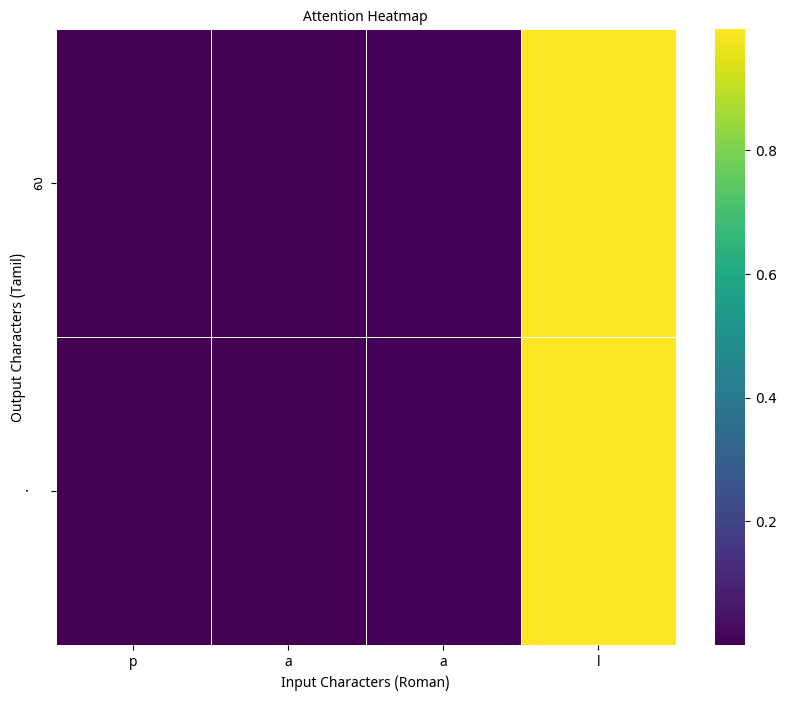

In [38]:
def visualize_attention(input_str, output_str, attention_weights):
    tamil_font_path = "/mnt/e_disk/DA6401_Assignment3/NotoSansTamil-VariableFont_wdth,wght.ttf"
    tamil_font = fm.FontProperties(fname=tamil_font_path)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights.cpu().numpy(),
                xticklabels=list(input_str),
                yticklabels=list(output_str),
                cmap='viridis',
                linewidths=0.5)
    plt.xlabel('Input Characters (Roman)', fontproperties=tamil_font)
    plt.ylabel('Output Characters (Tamil)', fontproperties=tamil_font)
    plt.title('Attention Heatmap', fontproperties=tamil_font)
    
    # Apply Tamil font to tick labels
    ax = plt.gca()
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=tamil_font)
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=tamil_font)
    
    plt.show()

def predict_with_attention(model, input_str, roman2idx, idx2devanagari, max_len=32):
    model.eval()
    input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
    input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)
        input_dec = torch.tensor([[devanagari2idx["<sos>"]]], dtype=torch.long).to(device)

        output_tokens = []
        attentions = []

        for _ in range(max_len):
            output, hidden, attn_weights = model.decoder(input_dec, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            if top1 == devanagari2idx["<eos>"]:
                break
            output_tokens.append(top1)
            attentions.append(attn_weights.squeeze(0))  # (src_len,)
            input_dec = torch.tensor([[top1]], dtype=torch.long).to(device)

    output_str = ''.join([idx2devanagari[i] for i in output_tokens])
    print(output_str)
    attention_matrix = torch.stack(attentions, dim=0)  # (tgt_len, src_len)
    return output_str, attention_matrix

input_word = "paal"
output_word, attn_weights = predict_with_attention(model, input_word, roman2idx, idx2devanagari)
visualize_attention(input_word, output_word, attn_weights)

ம்ம்ர்
்ம்ர்ம்
ம்ம்
்மார்ம்
்சிசேசிசிசிசிசிசிசிசிசிசிசிசிசி
சசசசசசசசசசசசுஷ்
ேசேசிசி
சசசசசசுஷ்
ஷ்ஸேஷ்


/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2990 (\N{TAMIL LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2992 (\N{TAMIL LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Noto Sans Tamil.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da640

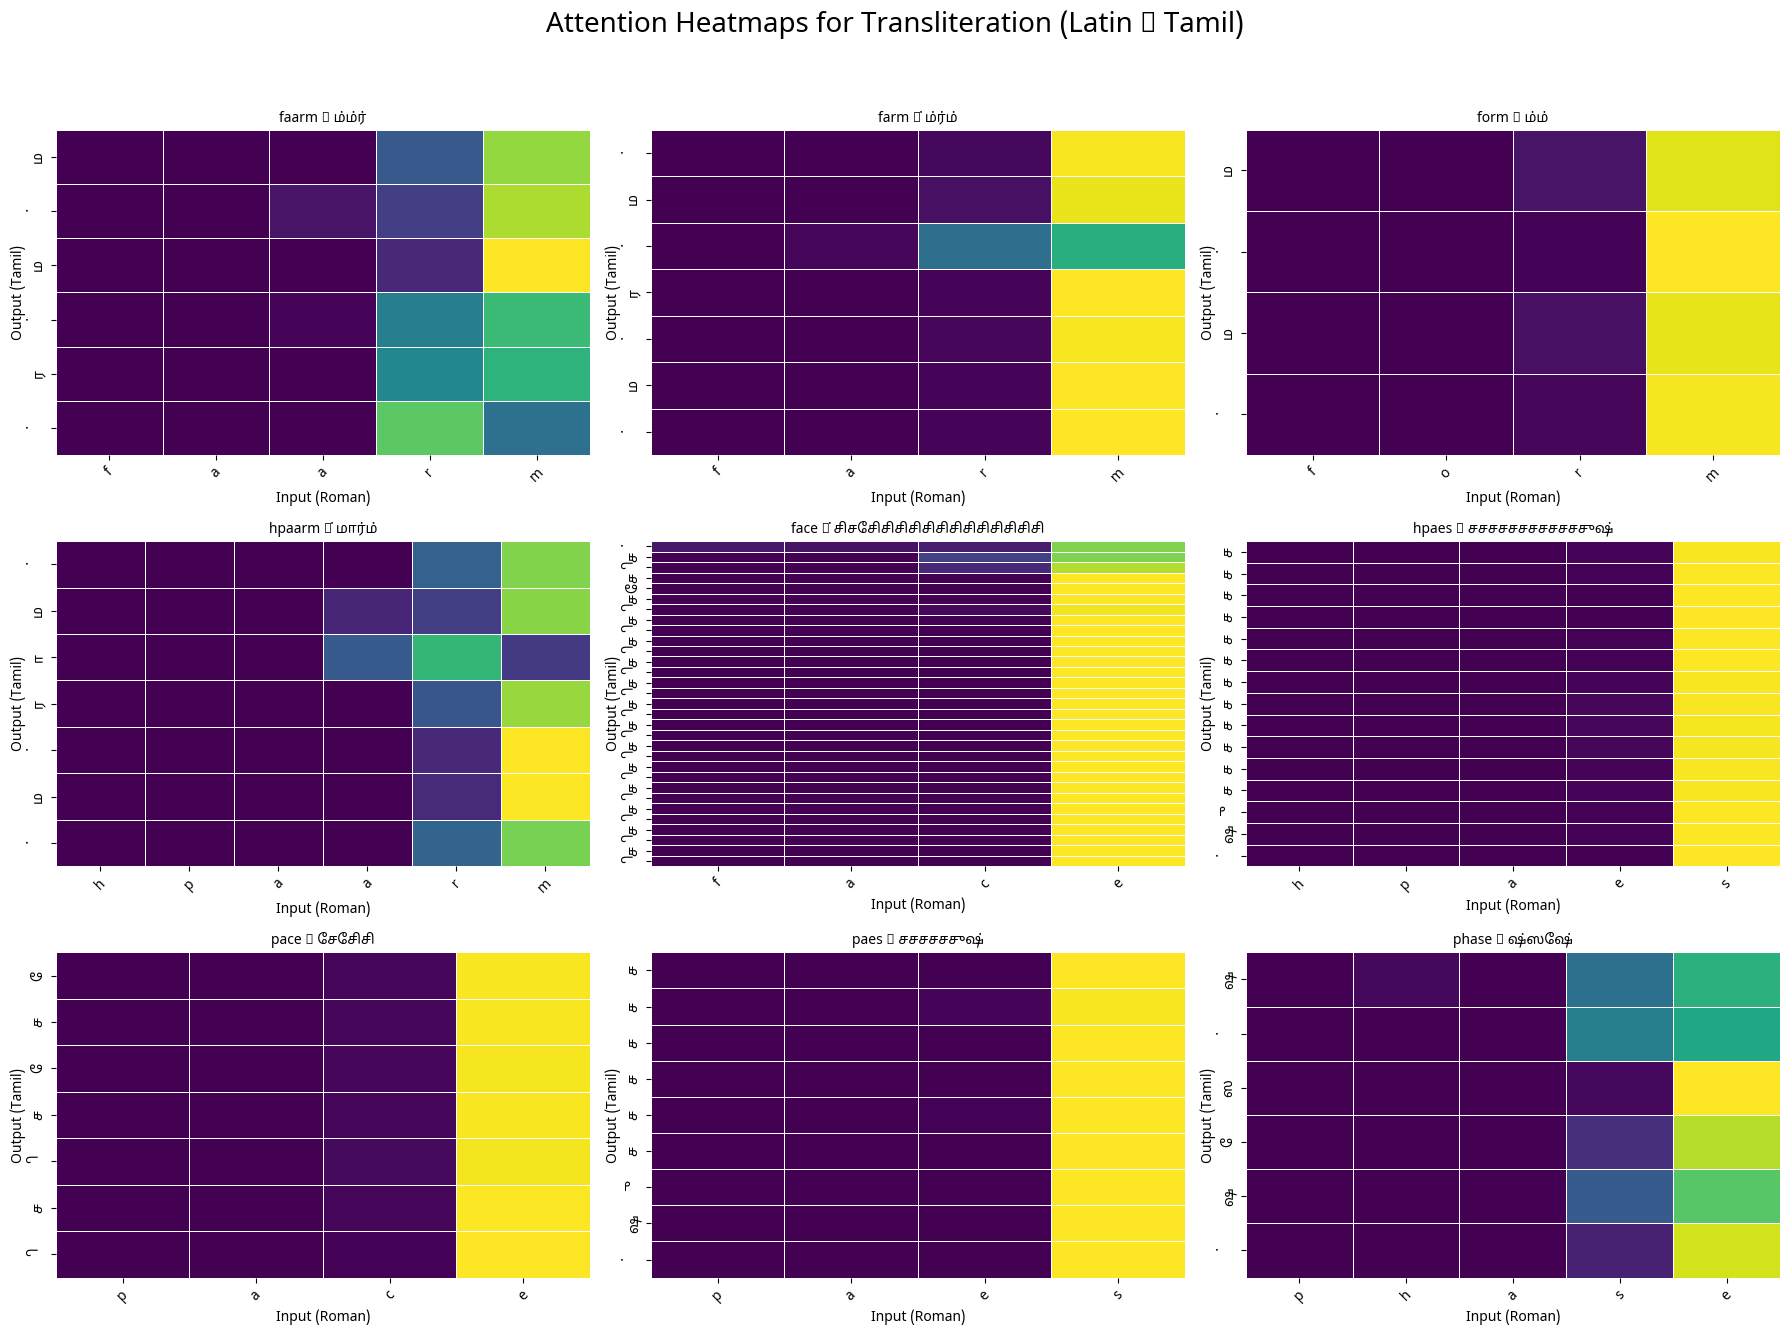

In [40]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import torch

# Load Tamil font
tamil_font_path = "/mnt/e_disk/DA6401_Assignment3/NotoSansTamil-VariableFont_wdth,wght.ttf"
tamil_font = fm.FontProperties(fname=tamil_font_path)

# Prepare to collect 9 test samples
samples = []
idx2roman = {v: k for k, v in roman2idx.items()}

# Load 9 samples from test loader
for batch in test_loader:
    if len(samples) >= 9:
        break
    input_tensor, target_tensor = batch
    input_indices = input_tensor[0].tolist()
    input_str = ''.join([idx2roman[i] for i in input_indices if i != roman2idx["<pad>"]])
    
    output_str, attn_weights = predict_with_attention(model, input_str, roman2idx, idx2devanagari)
    
    samples.append((input_str, output_str, attn_weights))

# Plot 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle("Attention Heatmaps for Transliteration (Latin → Tamil)", fontsize=20, fontproperties=tamil_font)

for i, (input_str, output_str, attn_weights) in enumerate(samples):
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    sns.heatmap(attn_weights.cpu().numpy(),
                xticklabels=list(input_str),
                yticklabels=list(output_str),
                cmap='viridis',
                linewidths=0.5,
                ax=ax,
                cbar=False)
    
    ax.set_xlabel("Input (Roman)", fontproperties=tamil_font)
    ax.set_ylabel("Output (Tamil)", fontproperties=tamil_font)
    ax.set_title(f"{input_str} → {output_str}", fontproperties=tamil_font)
    
    # Apply Tamil font to ticks
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=tamil_font)
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=tamil_font, rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Question 6

/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2992 (\N{TAMIL LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2990 (\N{TAMIL LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da6401_assignment3/.venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Noto Sans Tamil.
  fig.canvas.draw()
/mnt/e_disk/ch24s016/da640

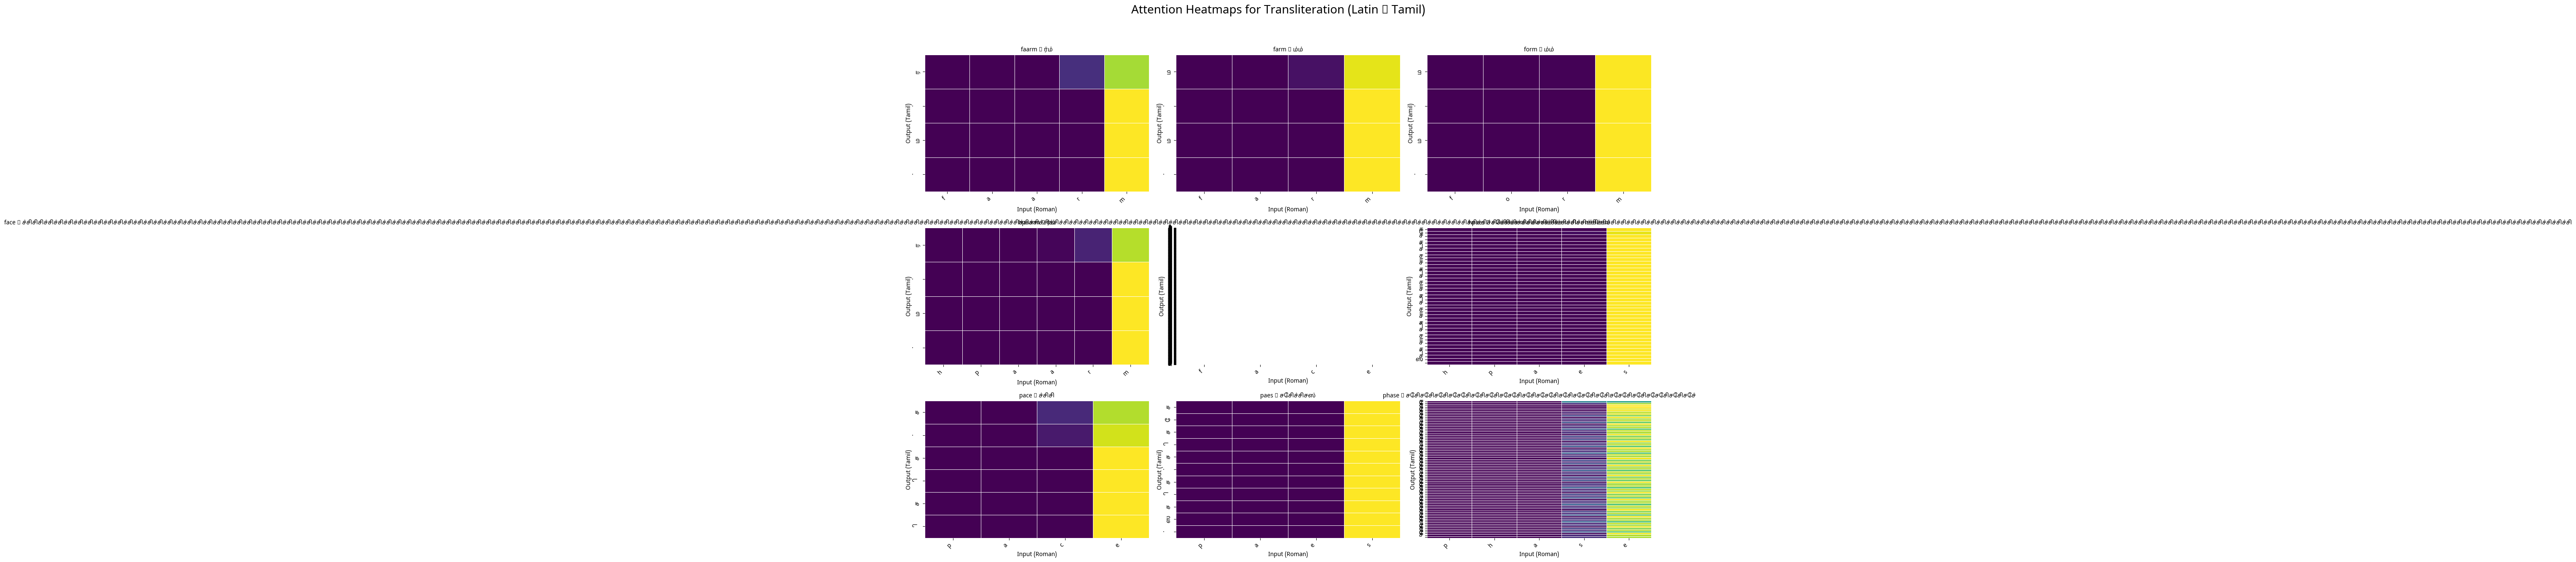

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Load Tamil font
tamil_font_path = "/mnt/e_disk/DA6401_Assignment3/NotoSansTamil-VariableFont_wdth,wght.ttf"
tamil_font = fm.FontProperties(fname=tamil_font_path)

# Reverse map
idx2roman = {v: k for k, v in roman2idx.items()}

# Function to get prediction + attention
def predict_with_attention(model, input_str, roman2idx, idx2devanagari, devanagari2idx, device=device, max_len=1024):
    model.eval()
    input_idxs = [roman2idx.get(c, roman2idx["<unk>"]) for c in input_str]
    input_tensor = torch.tensor(input_idxs, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_tensor)
        input_dec = torch.tensor([[devanagari2idx["<sos>"]]], dtype=torch.long).to(device)

        output_tokens = []
        attentions = []

        for _ in range(max_len):
            output, hidden, attn_weights = model.decoder(input_dec, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            if top1 == devanagari2idx["<eos>"]:
                break
            output_tokens.append(top1)
            attentions.append(attn_weights.squeeze(0))  # (src_len,)
            input_dec = torch.tensor([[top1]], dtype=torch.long).to(device)

    output_str = ''.join([idx2devanagari[i] for i in output_tokens])
    attention_matrix = torch.stack(attentions, dim=0)  # (tgt_len, src_len)

    return output_str, attention_matrix

# Prepare to collect 9 test samples
samples = []
for batch in test_loader:
    if len(samples) >= 9:
        break
    input_tensor, _ = batch
    input_indices = input_tensor[0].tolist()
    input_str = ''.join([idx2roman[i] for i in input_indices if i != roman2idx["<pad>"]])
    
    output_str, attn_weights = predict_with_attention(model, input_str, roman2idx, idx2devanagari, devanagari2idx)
    
    samples.append((input_str, output_str, attn_weights))

# Plot 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle("Attention Heatmaps for Transliteration (Latin → Tamil)", fontsize=20, fontproperties=tamil_font)

for i, (input_str, output_str, attn_weights) in enumerate(samples):
    row = i // 3
    col = i % 3
    ax = axes[row][col]

    sns.heatmap(attn_weights.cpu().numpy(),
                xticklabels=list(input_str),
                yticklabels=list(output_str),
                cmap='viridis',
                linewidths=0.5,
                ax=ax,
                cbar=False)

    ax.set_xlabel("Input (Roman)", fontproperties=tamil_font)
    ax.set_ylabel("Output (Tamil)", fontproperties=tamil_font)
    ax.set_title(f"{input_str} → {output_str}", fontproperties=tamil_font)

    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=tamil_font, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=tamil_font)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
